**Hyperopt**


In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PowerTransformer

import readLHE
import invariants
import glob
import scipy.special
import scipy.stats
import scipy.spatial
from numpy import inf
import pickle

def get_kl_js(data_p, data_q):
    pdfp = scipy.stats.rv_histogram(np.histogram(data_p, bins=100))
    pdfq = scipy.stats.rv_histogram(np.histogram(data_q, bins=100))
    p = pdfp.pdf(np.linspace(min(data_p), max(data_p), 100))
    q = pdfq.pdf(np.linspace(min(data_q), max(data_q), 100))
    kl_div = scipy.special.kl_div(p,q)
    kl_div[kl_div == inf] = 0
    js_div = scipy.spatial.distance.jensenshannon(p, q)**2
    return np.sum(kl_div), js_div

In [6]:
batch_size = [128, 256, 512]
learning_rate = [0.1, 0.01, 0.001]
epochs = [3e4, 4e4, 5e4]
optimizer = ['SGD', 'RMSprop', 'Adagrad']

In [7]:
with open('trials/trials.pickle', 'rb') as file, open('trials/trials_std.pickle', 'rb') as file_std:
    trials = pickle.load(file)
    trials_std = pickle.load(file_std)

#creo dataframe con i trials
trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]) for t in trials])
trials_std_df = pd.DataFrame([pd.Series(t['misc']['vals']) for t in trials_std])
for key in trials_df.keys():
    trials_df[key] =  [item for sublist in trials_df[key] for item in sublist]
    trials_std_df[key] =  [item2 for sublist2 in trials_std_df[key] for item2 in sublist2]

#aggiungo la kb-div
a = []
b = []
for t in trials_std:
    a.append(t['result']['loss'])
for s in trials:
    b.append(s['result']['loss'])

#sostituisco con i trial utilizzati
trials_df['batch_size'] = [batch_size[i] for i in trials_df['batch_size']]
trials_df['epochs'] = [epochs[i] for i in trials_df['epochs']]
trials_df['learning_rate'] = [learning_rate[i] for i in trials_df['learning_rate']]
trials_df['optimizer'] = [optimizer[i] for i in trials_df['optimizer']]

trials_df['preprocess'] = 'MinMax'
trials_df['loss'] = b

trials_std_df['batch_size'] = [batch_size[i] for i in trials_std_df['batch_size']]
trials_std_df['epochs'] = [epochs[i] for i in trials_std_df['epochs']]
trials_std_df['learning_rate'] = [learning_rate[i] for i in trials_std_df['learning_rate']]
trials_std_df['optimizer'] = [optimizer[i] for i in trials_std_df['optimizer']]

trials_std_df['preprocess'] = 'Standard'
trials_std_df['loss'] = a

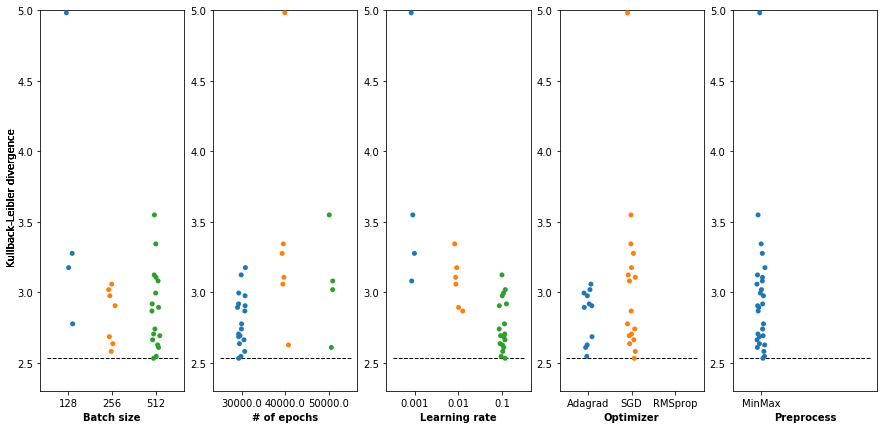

In [16]:
labels = ['Batch size', '# of epochs', 'Learning rate', 'Optimizer', 'Preprocess']
fig, axes = plt.subplots(1,5, figsize=(15,7))
for i in range(5):
    g = sns.stripplot(ax=axes[i], x=trials_df.keys()[i], y='loss', data=trials_df)
    axes[i].hlines(min(trials_df['loss']), -0.5, 2.5, linestyle='--', linewidth=1)
    axes[i].set_ylim(2.3, 5)
    axes[i].set_xlabel(labels[i], fontweight='bold')
    axes[i].set_ylabel('')
    axes[0].text(-1.4, 3.2, 'Kullback-Leibler divergence', rotation='vertical')

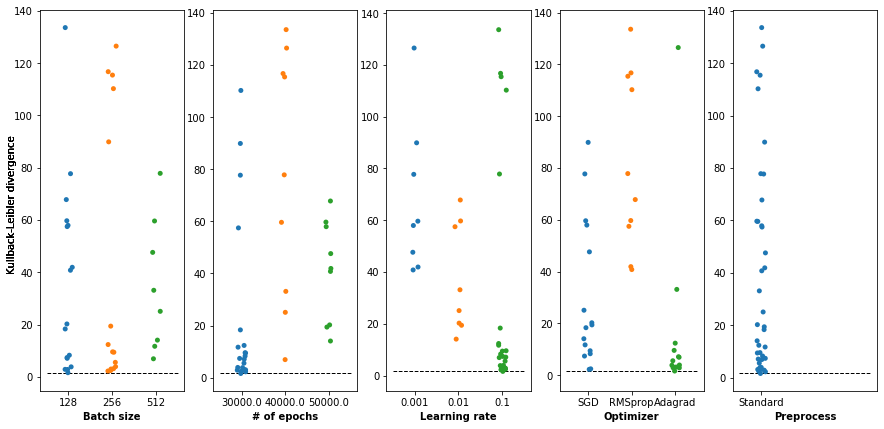

In [18]:
labels = ['Batch size', '# of epochs', 'Learning rate', 'Optimizer', 'Preprocess']
fig, axes = plt.subplots(1,5, figsize=(15,7))
for i in range(5):
    g = sns.stripplot(ax=axes[i], x=trials_std_df.keys()[i], y='loss', data=trials_std_df)
    axes[i].hlines(min(trials_std_df['loss']), -0.5, 2.5, linestyle='--', linewidth=1)
    axes[i].set_xlabel(labels[i], fontweight='bold')
    axes[i].set_ylabel('')
    axes[0].text(-1.4, 40.2, 'Kullback-Leibler divergence', rotation='vertical')

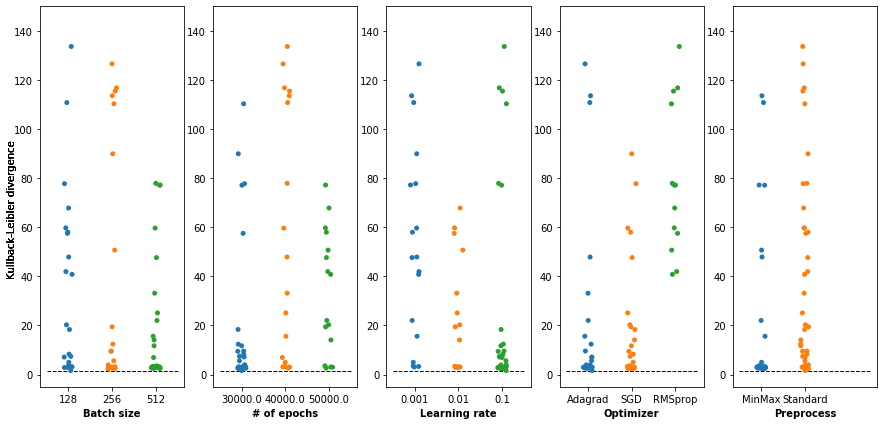

In [17]:
hyper_param = pd.concat([trials_df, trials_std_df], ignore_index=True)
labels = ['Batch size', '# of epochs', 'Learning rate', 'Optimizer', 'Preprocess']
fig, axes = plt.subplots(1,5, figsize=(15,7))
for i in range(5):
    g = sns.stripplot(ax=axes[i], x=hyper_param.keys()[i], y='loss', data=hyper_param)
    axes[i].hlines(min(hyper_param['loss']), -0.5, 2.5, linestyle='--', linewidth=1)
    axes[i].set_ylim(-5, 150)
    axes[i].set_xlabel(labels[i], fontweight='bold')
    axes[i].set_ylabel('')
    axes[0].text(-1.4, 40.2, 'Kullback-Leibler divergence', rotation='vertical')

**Confronto tra i sample - 30k epoche - SGD**

In [3]:
s_scaler = PowerTransformer(method='box-cox', standardize=True)
t_scaler = PowerTransformer(standardize=True)
minmax_scaler = MinMaxScaler((-1,1))

true = []
predictions = []
paths = glob.glob('outputs_trials/*')
for i in range(len(paths)):
    predictions.append(np.loadtxt(paths[i]+'/outputs/pred.txt'))
    evs = readLHE.readEvent(paths[i]+'/ppttbar.lhe')
    init = readLHE.readInit(paths[i]+'/ppttbar.lhe')
    true_dts = np.zeros((readLHE.NEvents(paths[i]+'/ppttbar.lhe'),3))
    j=0
    for ev in evs:
        true_dts[j,0] = invariants.GetEnergySquared(ev)
        true_dts[j,1] = invariants.GetMandelT(ev)
        true_dts[j,2] = invariants.GetRapidity(init, ev)
        j += 1
    true.append(true_dts)
    s_scaler = pickle.load(open(paths[i]+'/outputs/preprocess/s_scaler.pickle', 'rb'))
    t_scaler = pickle.load(open(paths[i]+'/outputs/preprocess/t_scaler.pickle', 'rb'))
    minmax_scaler = pickle.load(open(paths[i]+'/outputs/preprocess/minmax_scaler.pickle', 'rb'))
    
    predictions[i] = minmax_scaler.inverse_transform(predictions[i])
    predictions[i][:,0] = s_scaler.inverse_transform(predictions[i][:,0].reshape(-1,1)).flatten()
    predictions[i][:,1] = t_scaler.inverse_transform(predictions[i][:,1].reshape(-1,1)).flatten()

/Users/luigifavaro/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/luigifavaro/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/luigifavaro/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


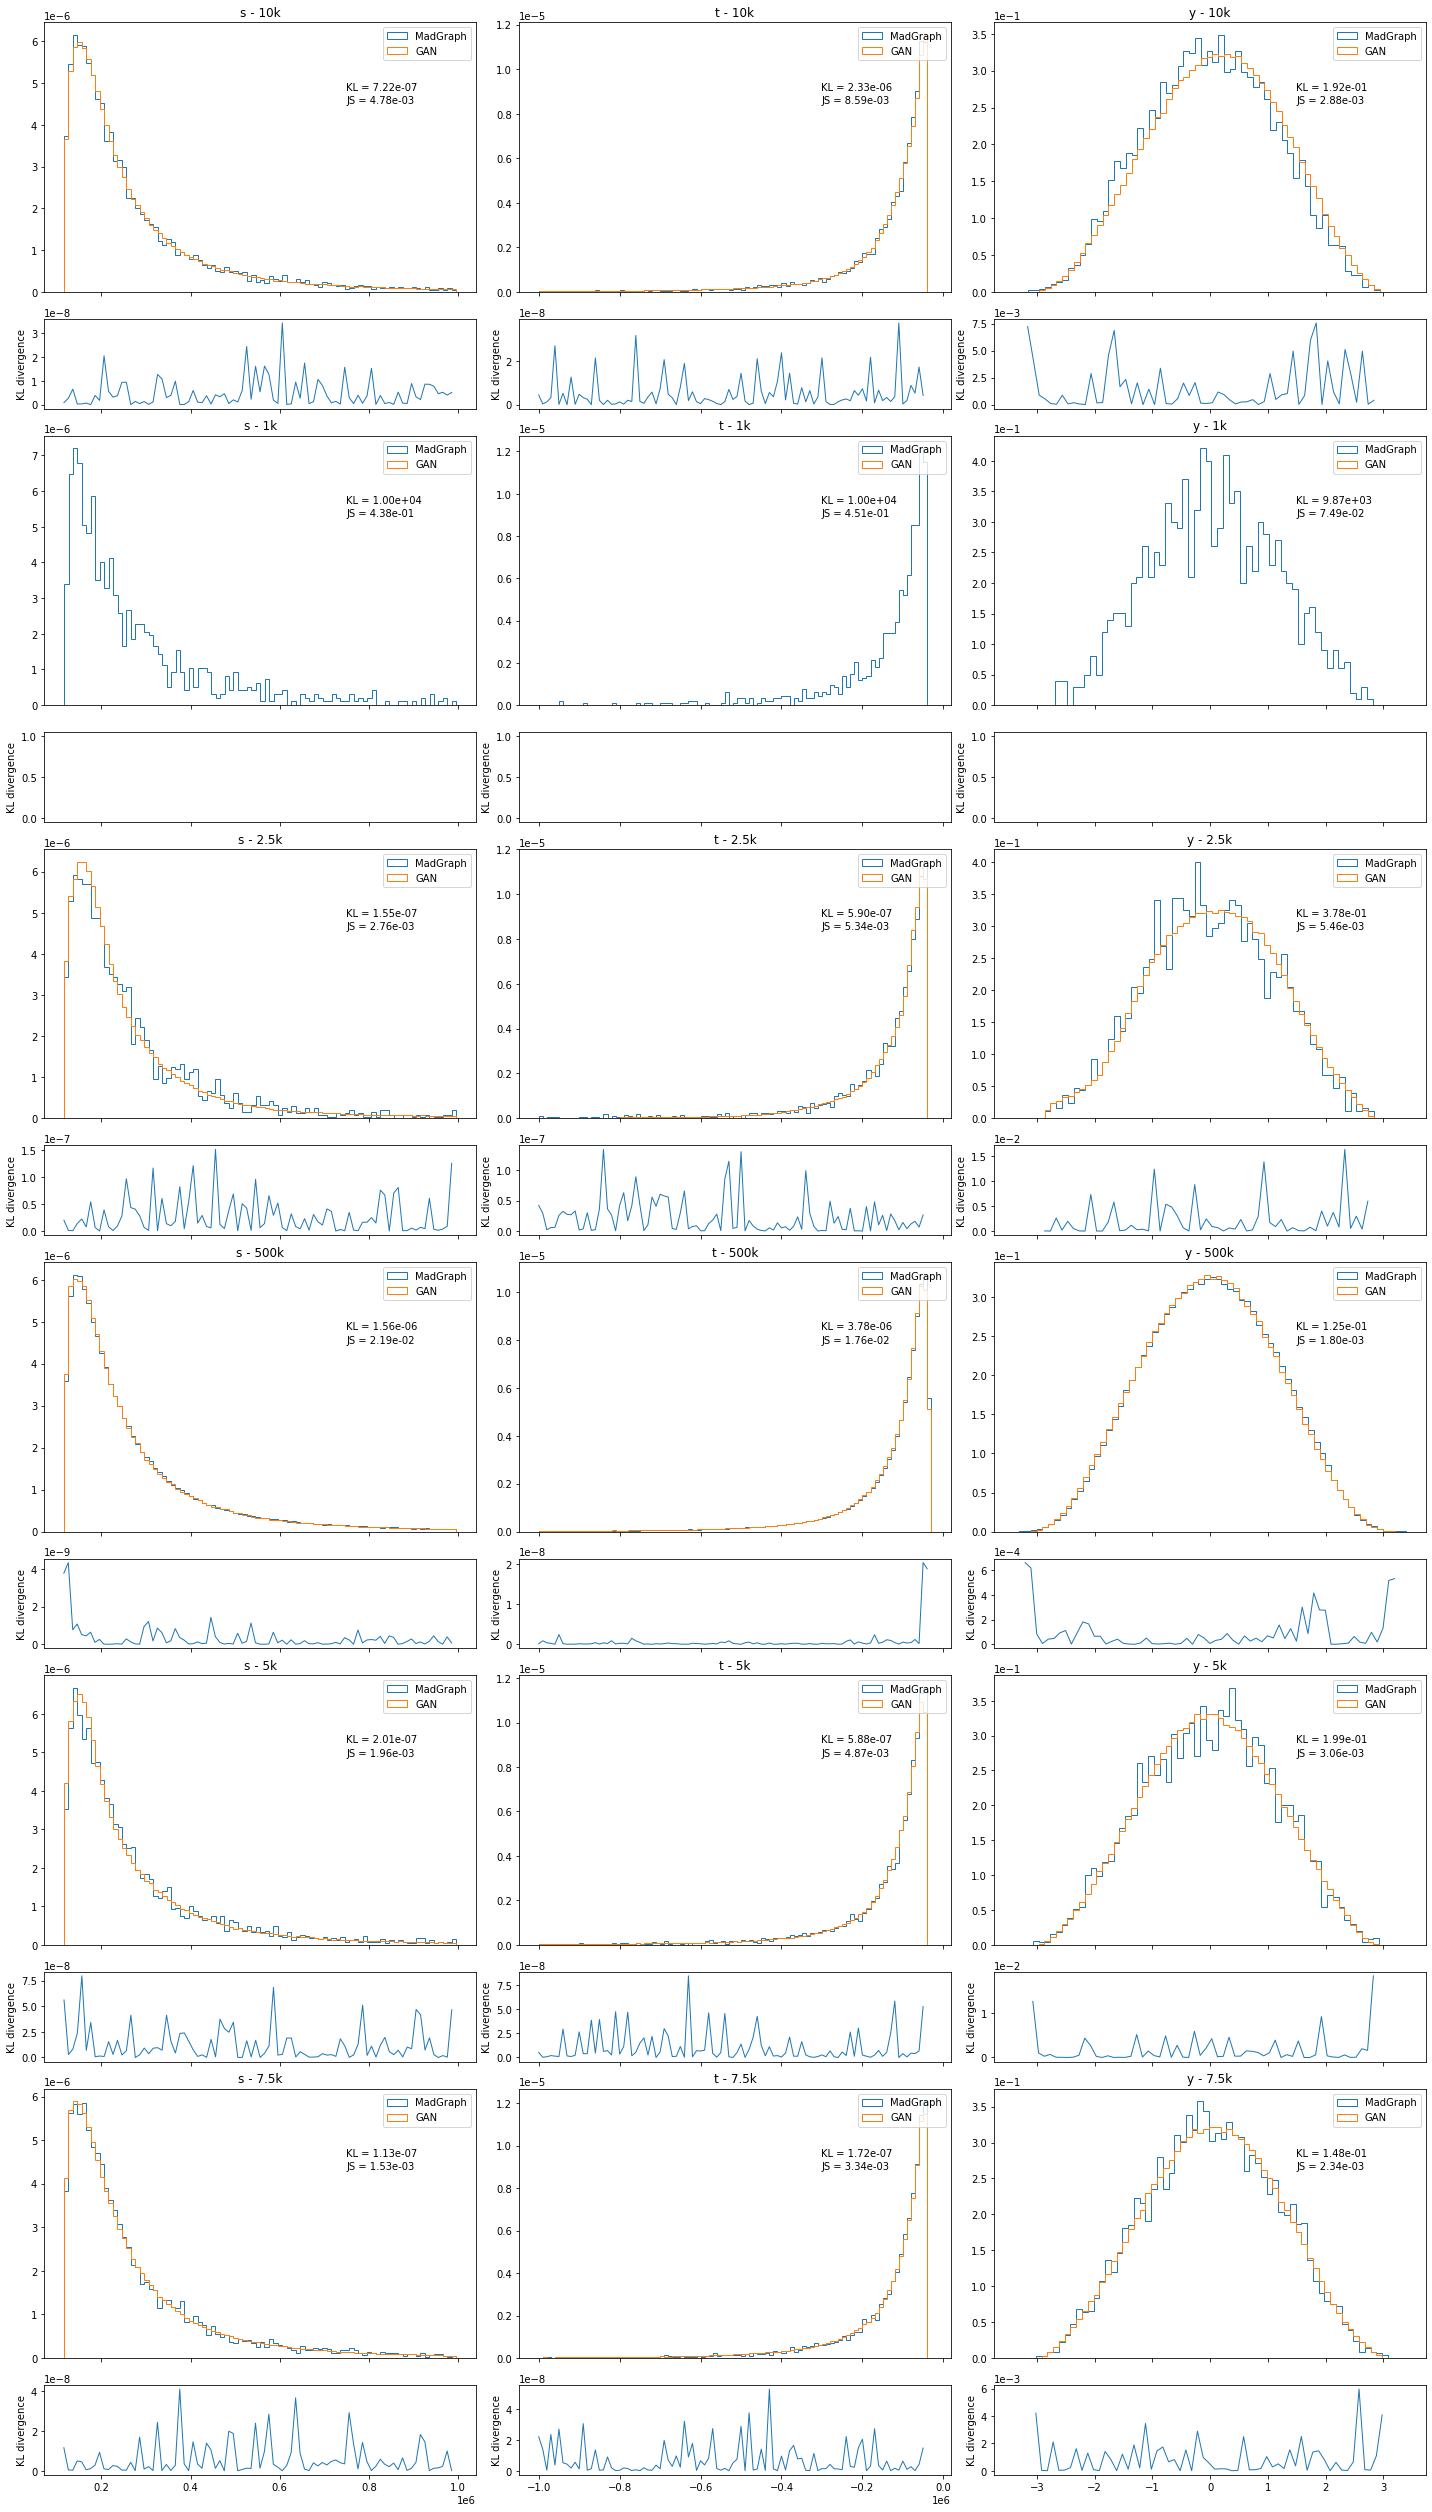

In [4]:
labels = ['s', 't', 'y']
events = ['10k', '1k', '2.5k', '500k', '5k', '7.5k']
fig, ax = plt.subplots(12,3, figsize=(20,35), gridspec_kw={'height_ratios': [3,1,3,1,3,1,3,1,3,1,3,1]}, sharex='col')

for j in range(len(predictions)):
    for i in range(3):
        bins = [np.arange(min(true[j][:,0]), 1e6, 1e4), np.arange(-1e6, max(true[j][:,1]), 1e4), np.arange(min(true[j][:,2]), max(true[j][:,2]), 0.1)]
        valt, bs, _ = ax[2*j,i].hist(true[j][:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
        valg, bs, _ = ax[2*j,i].hist(predictions[j][:,i], bins=bins[i], histtype='step', label='GAN', density=True)
        ax[2*j,i].set_title(labels[i]+' - '+events[j])
        ax[2*j,i].legend(loc='best')
        ax[2*j,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(true[j][:,i], predictions[j][:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
        ax[2*j,i].annotate('JS = {:.2e}'.format(get_kl_js(true[j][:,i], predictions[j][:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
        ax[2*j,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
        ax[2*j+1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
        ax[2*j+1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
        ax[2*j+1,i].set_ylabel('KL divergence')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

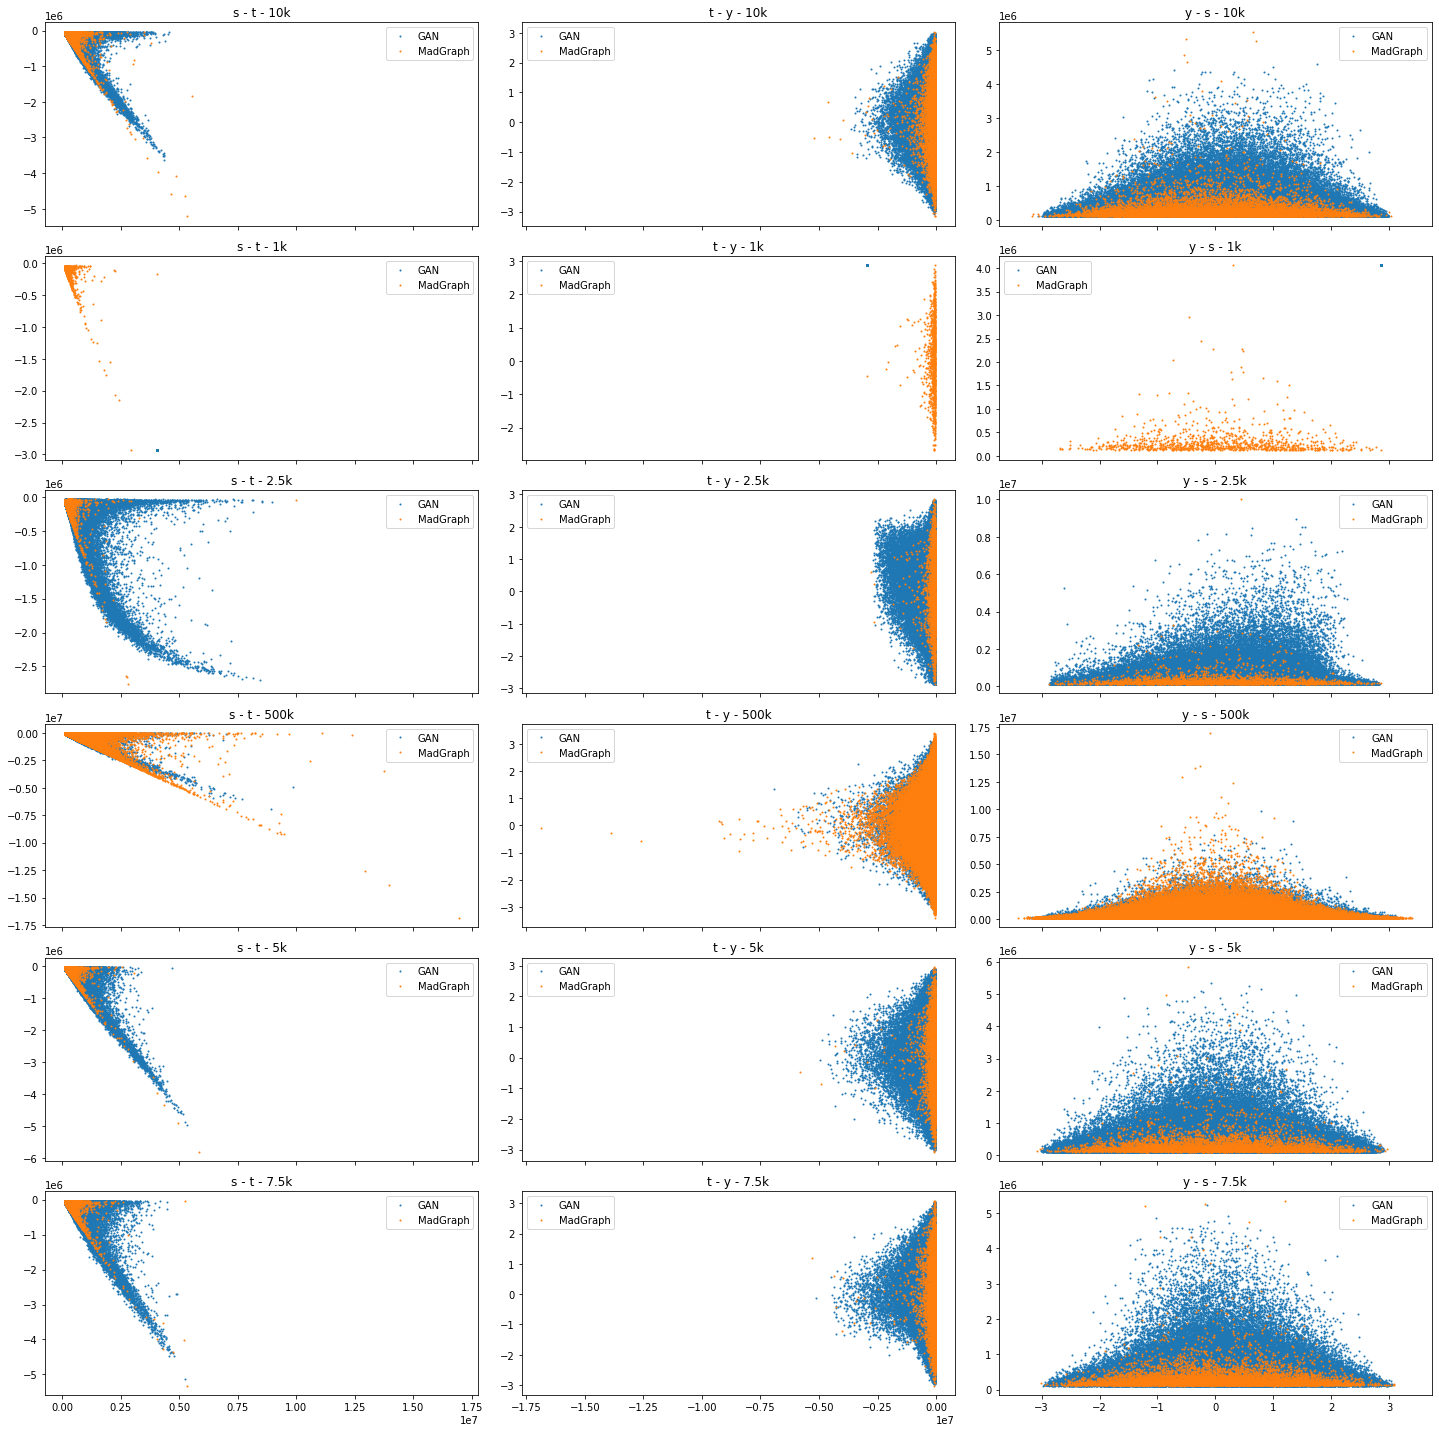

In [5]:
labels = ['s - t', 't - y', 'y - s']
fig, ax = plt.subplots(6,3, figsize=(20,20), sharex='col')

for j in range(len(predictions)):
    for i in range(3):
        bins = [np.arange(min(true[j][:,0]), 1e6, 1e4), np.arange(-1e6, max(true[j][:,1]), 1e4), np.arange(min(true[j][:,2]), max(true[j][:,2]), 0.1)]
        ax[j,i].plot(predictions[j][:,i], predictions[j][:,(i+1)%3], 'o', markersize=1, label='GAN')
        ax[j,i].plot(true[j][:,i%3], true[j][:,(i+1)%3],'o', markersize=1, label='MadGraph')
        ax[j,i].set_title(labels[i]+' - '+events[j])
        ax[j,i].legend(loc='best')
        ax[j,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

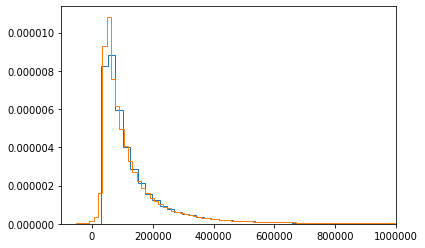

In [11]:
plt.hist(true[3][:,0]+true[3][:,1], bins=500, histtype='step', density=True)
plt.hist(predictions[3][:,0]+predictions[3][:,1], bins=500, histtype='step', density=True)
plt.xlim(-1e5, 1e6)
plt.show()

/Users/luigifavaro/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


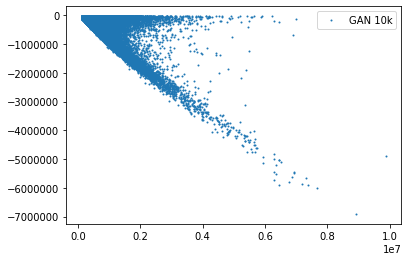

In [19]:
#plt.plot(true[3][:,0], true[3][:,1], 'o', markersize=1, label='MG 500k')
#plt.plot(true[0][:,0], true[0][:,1], 'o', markersize=1, label='MG 500k')
#plt.plot(predictions[3][:,0], predictions[3][:,1], 'o', markersize=1, label='GAN 500k')
plt.plot(predictions[3][:,0], predictions[3][:,1], 'o', markersize=1, label='GAN 10k')
plt.legend()
#plt.xlim(0.01e7,0.07e7)
#plt.ylim(-0.2e6,0)

In [19]:
epochs_lr = [1e4, 3e4]
opt = ['Adam', 'Adamax', 'Adagrad', 'Adadelta']
with open('trials/trials_lr.pickle', 'rb') as file:
    trials_lr = pickle.load(file)

#creo dataframe con i trials
trials_lr_df = pd.DataFrame([pd.Series(t['misc']['vals']) for t in trials_lr])
for key in trials_lr_df.keys():
    trials_lr_df[key] =  [item2 for sublist2 in trials_lr_df[key] for item2 in sublist2]

#aggiungo la kb-div
c = []
for t in trials_lr:
    c.append(t['result']['loss'])
    
trials_lr_df['epochs'] = [epochs_lr[i] for i in trials_lr_df['epochs']]
trials_lr_df['optimizer'] = [opt[i] for i in trials_lr_df['optimizer']]
trials_lr_df['loss'] = c

Text(0.5, 0, 'Learning rate')

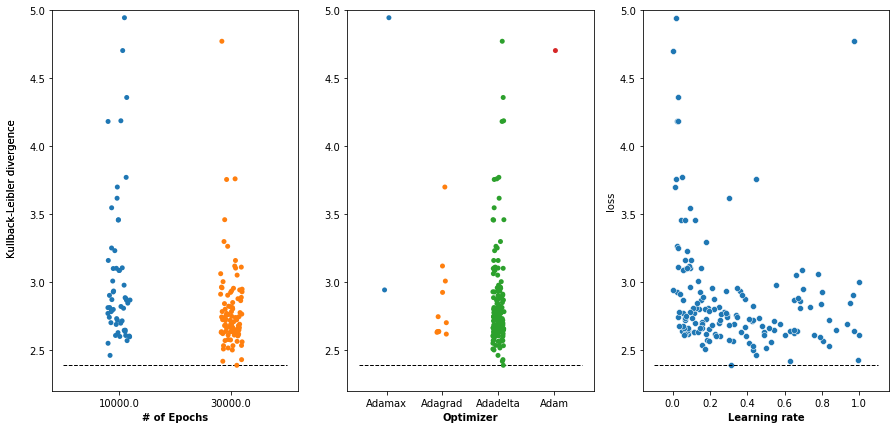

In [45]:
keys = ['epochs', 'optimizer']
h_ranges = [(-0.5, 1.5), (-0.5, 3.5)]
labels = ['# of Epochs', 'Optimizer']
fig, axes = plt.subplots(1,3, figsize=(15,7))
for i in range(2):
    g = sns.stripplot(ax=axes[i], x=keys[i], y='loss', data=trials_lr_df)
    axes[i].hlines(min(trials_lr_df['loss']), h_ranges[i][0], h_ranges[i][1], linestyle='--', linewidth=1)
    axes[i].set_ylim(2.2, 5)
    axes[i].set_xlabel(labels[i], fontweight='bold')
    axes[i].set_ylabel('')
    axes[0].text(-1., 3.2, 'Kullback-Leibler divergence', rotation='vertical')
g = sns.scatterplot(data=trials_lr_df, x='learning_rate', y='loss', ax=axes[2])
g.set_ylim(2.2, 5)
axes[2].hlines(min(trials_lr_df['loss']), -0.1, 1.1, linestyle='--', linewidth=1)
axes[2].set_xlabel('Learning rate', fontweight='bold')

In [48]:
min(trials_lr_df['loss'])

2.387753512989692